In [4]:
import joblib
import sklearn
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import time
import xarray as xr
import rioxarray
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.transform import from_origin
from sklearn.neighbors import KDTree 



In [5]:

# Load models
model_CL1 = joblib.load('./model_ALLcities_CL1.joblib') 
model_CL2 = joblib.load('./model_ALLcities_CL2.joblib')
model_CL3 = joblib.load('./model_ALLcities_CL3.joblib')

# Define city groups
CL1_cities = {
    "Belgrado", "Berlin", "Charleroi", "Frankfurt_am_Main", "Ljubljana",
    "Lodz", "Lyon", "Madrid", "Sofia", "Szeged", "Vilnius"
}
CL2_cities = {
    "Bari", "Marseille", "Naples", "Palma_de_Mallorca",
    "Rome", "Sevilla", "Tirana"
}
CL3_cities = {
    "Brussels", "Gdansk", "Hamburg", "Newcastle",
    "Oslo", "Reykjavik", "Tallinn"
}
columns_order = ['LC_CORINE', 'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP', 
                 'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC', 'CAPE', 
                 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL']

city_clusters = {
    "CL1": CL1_cities,
    #"CL2": CL2_cities,
    #"CL3": CL3_cities
}

models = {
    "CL1": model_CL1,
    "CL2": model_CL2,
    "CL3": model_CL3
}


In [ ]:

min_max_file = "data/total_min_max.csv"
min_max_df = pd.read_csv(min_max_file, sep=';')
input_ranges = min_max_df['Max'] - min_max_df['min']
input_ranges.index = min_max_df['Unnamed: 0']

t_target_min = min_max_df.loc[16, 'min']
t_target_max = min_max_df.loc[16, 'Max']
delta = 0.1 * input_ranges

allowed_sensitivity_columns = ['HEIGHT', 'POP', 'IMPERV']
allowed_indices = [columns_order.index(col) for col in allowed_sensitivity_columns]
midpoints = {
    row['Unnamed: 0']: (row['min'] + row['Max']) / 2
    for _, row in min_max_df.iterrows()
    if row['Unnamed: 0'] in allowed_sensitivity_columns
}

warnings.filterwarnings("ignore")

for cluster, cities in city_clusters.items():
    model = models[cluster]
    for city in cities:
        print(f"Processing {city} in cluster {cluster}...")
        file_path = f"data/raster_total/total_{city}.csv"
        data = pd.read_csv(file_path).dropna()

        # Manual feature overrides
        data['SP'] = 102000
        data['RH'] = 30
        data['PRECIP'] = 0
        data['WS'] = 1
        data['T_2M_COR'] = 298
        data['TCC'] = 0
        data['BLH'] = 150
        data['SSR'] = 0
        data['SOLAR_ELEV'] = -50
        data['DECL'] = 20
        data['CAPE'] = 500
        data['T_2M_COR'] = data['T_2M_COR'] - 273.15
        data2 = data[columns_order]

        n_allowed = len(allowed_indices)
        sample_plus = np.repeat(data2, n_allowed, axis=0)
        sample_minus = np.repeat(data2, n_allowed, axis=0)

        for idx_in_allowed, feature_idx in enumerate(allowed_indices):
            sample_minus[idx_in_allowed::n_allowed, feature_idx] -= 0.5 * sample_minus[idx_in_allowed::n_allowed, feature_idx]

        if np.any(np.isnan(sample_plus)) or np.any(np.isnan(sample_minus)):
            print("NaNs in perturbed samples — replacing with midpoints.")
            for idx_in_allowed, feature_idx in enumerate(allowed_indices):
                feature_name = allowed_sensitivity_columns[idx_in_allowed]
                midpoint = midpoints[feature_name]
                sample_plus[np.isnan(sample_plus[:, feature_idx]), feature_idx] = midpoint
                sample_minus[np.isnan(sample_minus[:, feature_idx]), feature_idx] = midpoint

        sample_plus = np.clip(sample_plus, -1e10, 1e10)
        sample_minus = np.clip(sample_minus, -1e10, 1e10)
        perturbations = np.vstack((sample_plus, sample_minus))

        try:
            outputs = model.predict(perturbations)
        except ValueError as e:
            print(f"Prediction error for {city}: {e}")
            continue

        output_plus = outputs[:len(data) * n_allowed].reshape(len(data), n_allowed)
        output_minus = outputs[len(data) * n_allowed:].reshape(len(data), n_allowed)
        sensitivities_batch = (output_minus - output_plus)

        # Assign sensitivity results to DataFrame
        data = data.reset_index(drop=True)
        for i, feature in enumerate(allowed_sensitivity_columns):
            data[f"SI_{feature}"] = sensitivities_batch[:, i]

        # Create save directory
        save_dir = os.path.join("Figures", cluster, "case_studies")
        os.makedirs(save_dir, exist_ok=True)

        # Plot and save each sensitivity map
        for feature, vmin in zip(allowed_sensitivity_columns, [-0.5, -0.5, -0.5]):
            fig, ax = plt.subplots(figsize=(10, 8))
            sc = ax.scatter(data['x'], data['y'], c=data[f'SI_{feature}'], cmap='RdYlGn_r', s=5, alpha=0.8,
                            vmax=0, vmin=vmin)
    
            # Add colorbar with customized height
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.1)
            cbar = fig.colorbar(sc, cax=cax)
            cbar.set_label('Reduced temperature [K]')

            # Reduce colorbar height manually (e.g., 60% of the plot height)
            pos = cax.get_position()
            cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
            #ax.set_title(f'Sensitivity to {feature}')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            save_path = os.path.join(save_dir, f"{city}_{feature}.png")
            plt.savefig(save_path, dpi=300)
            plt.close()

Processing Belgrado in cluster CL1...
Processing Berlin in cluster CL1...
Processing Sofia in cluster CL1...
Processing Madrid in cluster CL1...
Processing Ljubljana in cluster CL1...
Processing Lodz in cluster CL1...
Processing Frankfurt_am_Main in cluster CL1...
Processing Charleroi in cluster CL1...
Processing Vilnius in cluster CL1...
Processing Lyon in cluster CL1...
Processing Szeged in cluster CL1...
Processing Rome in cluster CL2...
Processing Palma_de_Mallorca in cluster CL2...
Processing Naples in cluster CL2...
Processing Tirana in cluster CL2...
Processing Bari in cluster CL2...
Processing Marseille in cluster CL2...
Processing Sevilla in cluster CL2...
Processing Oslo in cluster CL3...
Processing Newcastle in cluster CL3...
Processing Brussels in cluster CL3...
Processing Gdansk in cluster CL3...
Processing Tallinn in cluster CL3...
Processing Reykjavik in cluster CL3...
Processing Hamburg in cluster CL3...


In [3]:

#saving the predictions
warnings.filterwarnings("ignore")
min_max_df = pd.read_csv("data/total_min_max.csv", sep=';')
input_ranges = min_max_df['Max'] - min_max_df['min']
input_ranges.index = min_max_df['Unnamed: 0']
midpoints = {
    row['Unnamed: 0']: (row['min'] + row['Max']) / 2
    for _, row in min_max_df.iterrows()
    if row['Unnamed: 0'] in ['HEIGHT', 'POP', 'IMPERV']
}
allowed_sensitivity_columns = ['HEIGHT', 'POP', 'IMPERV']
allowed_indices = [columns_order.index(col) for col in allowed_sensitivity_columns]


for cluster, cities in city_clusters.items():
    model = models[cluster]

    time_start = time.time()
    for city in cities:
        file_path = f"data/raster_total/total_{city}.csv"
        if not os.path.exists(file_path):
            print(f"Missing file for {city}")
            continue

        print(f"Running model predictions for {city}...")
        data = pd.read_csv(file_path).dropna()
        
        # Manual overrides
        data['SP'] = 102000
        data['RH'] = 30
        data['PRECIP'] = 0
        data['WS'] = 1
        data['T_2M_COR'] = 298 #295
        data['TCC'] = 0
        data['BLH'] = 150
        data['SSR'] = 0
        data['SOLAR_ELEV'] = -50 #-30
        data['DECL'] = 20
        data['CAPE'] = 500
        #voor CL3: T2m verlagen, naar 295, SOLAR_ELEV verhogen, pakt -30. rest lijkt ok
        #voor CL1: alles zou moeten ok zijn.

        base_data = data[columns_order].to_numpy()
        n_allowed = len(allowed_indices)

        sample_plus = np.repeat(base_data, n_allowed, axis=0)
        sample_minus = np.repeat(base_data, n_allowed, axis=0)

        for idx_in_allowed, feature_idx in enumerate(allowed_indices):
            sample_minus[idx_in_allowed::n_allowed, feature_idx] -= 0.5 * sample_minus[idx_in_allowed::n_allowed, feature_idx]

        for idx_in_allowed, feature_idx in enumerate(allowed_indices):
            feature_name = allowed_sensitivity_columns[idx_in_allowed]
            midpoint = midpoints[feature_name]
            sample_plus[np.isnan(sample_plus[:, feature_idx]), feature_idx] = midpoint
            sample_minus[np.isnan(sample_minus[:, feature_idx]), feature_idx] = midpoint

        sample_plus = np.clip(sample_plus, -1e10, 1e10)
        sample_minus = np.clip(sample_minus, -1e10, 1e10)
        perturbations = np.vstack((sample_plus, sample_minus))

        try:
            outputs = model.predict(perturbations)
        except ValueError as e:
            print(f"Prediction error for {city}: {e}")
            continue

        output_plus = outputs[:len(data) * n_allowed].reshape(len(data), n_allowed)
        output_minus = outputs[len(data) * n_allowed:].reshape(len(data), n_allowed)
        sensitivities_batch = (output_minus - output_plus)

        for i, feature in enumerate(allowed_sensitivity_columns):
            data[f"SI_{feature}"] = sensitivities_batch[:, i]
        duration = time.time() - time_start
        print(f"{city} processed in {duration:.2f}s")

        save_dir = f"results/{cluster}"
        os.makedirs(save_dir, exist_ok=True)
        data.to_csv(os.path.join(save_dir, f"{city}_pred.csv"), index=False)
        time_start = time.time()


Running model predictions for Lyon...
Lyon processed in 1.33s
Running model predictions for Vilnius...
Vilnius processed in 1.66s
Running model predictions for Madrid...
Madrid processed in 1.13s
Running model predictions for Sofia...
Sofia processed in 1.01s
Running model predictions for Lodz...
Lodz processed in 1.27s
Running model predictions for Frankfurt_am_Main...
Frankfurt_am_Main processed in 1.05s
Running model predictions for Belgrado...
Belgrado processed in 1.38s
Running model predictions for Charleroi...
Charleroi processed in 0.57s
Running model predictions for Berlin...
Berlin processed in 1.82s
Running model predictions for Szeged...
Szeged processed in 0.74s
Running model predictions for Ljubljana...
Ljubljana processed in 0.73s


In [ ]:
#with addition of AOA visualisation, doesn't work because of different joblib versions :))
importance_to_column_map = {
    'IMPERV': 'IMPERV',
    'HEIGHT': 'HEIGHT',
    'COAST': 'COAST',
    'ELEV': 'ELEV',
    'POP': 'POP',
    'RH': 'RH',
    'SP': 'SP',
    'PRECIP': 'PRECIP',
    'T_2M': 'T_2M_COR',  # Important mapping
    'wind_speed': 'WS',
    'TCC': 'TCC',
    'CAPE': 'CAPE',
    'BLH': 'BLH',
    'SSR': 'SSR',
    'SOLAR_ELEV': 'SOLAR_ELEV',
    'DECL': 'DECL'
}

scaling_factors = {
    "CL1": 0.7118433562961,
    "CL2": 0.668705723715955,
    "CL3": 0.722033013807132
}
def min_max_scale(data, min_vals, scale):
    return (data - min_vals) / scale
min_max_file = "data/total_min_max.csv"
min_max_df = pd.read_csv(min_max_file, sep=';')
input_ranges = min_max_df['Max'] - min_max_df['min']
input_ranges.index = min_max_df['Unnamed: 0']

t_target_min = min_max_df.loc[16, 'min']
t_target_max = min_max_df.loc[16, 'Max']
delta = 0.1 * input_ranges

allowed_sensitivity_columns = ['HEIGHT', 'POP', 'IMPERV']
allowed_indices = [columns_order.index(col) for col in allowed_sensitivity_columns]
midpoints = {
    row['Unnamed: 0']: (row['min'] + row['Max']) / 2
    for _, row in min_max_df.iterrows()
    if row['Unnamed: 0'] in allowed_sensitivity_columns
}
warnings.filterwarnings("ignore")

for cluster, cities in city_clusters.items():
    columns_order = [
        'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP',  
        'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC',  
        'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL'
    ]
    model = models[cluster]
    scaling_factor = scaling_factors[cluster]

    # Load cluster-specific min-max
    min_max_df_cluster = pd.read_csv(f"data/CLUSTER{cluster[-1]}_min_max.csv", sep=';')
    min_max_df_cluster.set_index(min_max_df_cluster.columns[0], inplace=True)

    min_vals = min_max_df_cluster.loc[columns_order, 'min'].astype(float).to_numpy()
    max_vals = min_max_df_cluster.loc[columns_order, 'Max'].astype(float).to_numpy()
    scale = max_vals - min_vals
    scale[scale == 0] = 1.0  # Avoid division by zero

    # Load cluster-specific feature importances
    importances_df = pd.read_csv(f'AOA_data/importances_{cluster}.csv')
    importances_df.set_index('Feature', inplace=True)
    weights = np.array([
        importances_df.loc[feature, 'Importance'] 
        for feature in importance_to_column_map 
        if importance_to_column_map[feature] in columns_order
    ])

    thresholds = pd.read_csv(f'results/Thresholds_AOA_{cluster}.csv')

    for city in cities:
        print(f"Processing {city} in cluster {cluster}...")

        file_path = f"data/raster_total/total_{city}.csv"
        data = pd.read_csv(file_path).dropna()

        # Manual overrides
        data['SP'] = 102000
        data['RH'] = 30
        data['PRECIP'] = 0
        data['WS'] = 1
        data['T_2M_COR'] = 298
        data['TCC'] = 0
        data['BLH'] = 150
        data['SSR'] = 0
        data['SOLAR_ELEV'] = -50
        data['DECL'] = 20
        data['CAPE'] = 500


        # Preserve original temp for AOA
        data_aoa = data.copy()

        # --- AOA CALCULATION ---
        data_scaled = min_max_scale(data_aoa[columns_order].to_numpy(), min_vals, scale)
        weighted_features = data_scaled * weights
        lc_values = data_aoa['LC_CORINE'].values

        data_dists = np.full(len(data), np.inf)
        for lc_class in np.unique(lc_values):
            tree_path = f'trees/{cluster}/CLUSTER{cluster[-1]}_KDTREE_{lc_class}.joblib'
            current_tree = joblib.load(tree_path)
            mask = lc_values == lc_class
            dists, _ = current_tree.query(weighted_features[mask], k=1)
            data_dists[mask] = dists.flatten()

        distances_list = data_dists / scaling_factor
        data['dists'] = distances_list

        AOA_array = np.full(len(data), np.inf)
        for lc_class in np.unique(lc_values):
            mask = lc_values == lc_class
            threshold = thresholds.loc[thresholds['LC_CORINE'] == lc_class, 'Threshold'].values[0]
            AOA_array[mask] = distances_list[mask] <= threshold

        data['AOA'] = AOA_array.astype(int)

        # Subtract 273.15 for model + plotting only (NOT AOA)
        data['T_2M_COR'] = data['T_2M_COR'] - 273.15
        #data2 = data[columns_order]

        # Sensitivity analysis
        n_allowed = len(allowed_indices)
        base_data = data[columns_order].to_numpy()
        sample_plus = np.repeat(base_data, n_allowed, axis=0)
        sample_minus = np.repeat(base_data, n_allowed, axis=0)

        for idx_in_allowed, feature_idx in enumerate(allowed_indices):
            sample_minus[idx_in_allowed::n_allowed, feature_idx] -= 0.5 * sample_minus[idx_in_allowed::n_allowed, feature_idx]

        if np.any(np.isnan(sample_plus)) or np.any(np.isnan(sample_minus)):
            print("NaNs in perturbed samples — replacing with midpoints.")
            for idx_in_allowed, feature_idx in enumerate(allowed_indices):
                feature_name = allowed_sensitivity_columns[idx_in_allowed]
                midpoint = midpoints[feature_name]
                sample_plus[np.isnan(sample_plus[:, feature_idx]), feature_idx] = midpoint
                sample_minus[np.isnan(sample_minus[:, feature_idx]), feature_idx] = midpoint

        sample_plus = np.clip(sample_plus, -1e10, 1e10)
        sample_minus = np.clip(sample_minus, -1e10, 1e10)
        perturbations = np.vstack((sample_plus, sample_minus))

        try:
            outputs = model.predict(perturbations)
        except ValueError as e:
            print(f"Prediction error for {city}: {e}")
            continue

        output_plus = outputs[:len(data) * n_allowed].reshape(len(data), n_allowed)
        output_minus = outputs[len(data) * n_allowed:].reshape(len(data), n_allowed)
        sensitivities_batch = (output_minus - output_plus)

        # Assign sensitivity results to DataFrame
        data = data.reset_index(drop=True)
        for i, feature in enumerate(allowed_sensitivity_columns):
            data[f"SI_{feature}"] = sensitivities_batch[:, i]

        # ---- PLOTTING SECTION ----
        for feature, vmin in zip(allowed_sensitivity_columns, [-0.5, -0.5, -0.5]):
            fig, ax = plt.subplots(figsize=(10, 8))

            # Plot normally colored points (AOA==1)
            mask_valid = data['AOA'] == 1
            sc = ax.scatter(data.loc[mask_valid, 'x'], data.loc[mask_valid, 'y'],
                            c=data.loc[mask_valid, f'SI_{feature}'], cmap='RdYlGn_r',
                            s=5, alpha=0.8, vmax=0, vmin=vmin)

            # Plot black pixels for AOA==0
            mask_invalid = data['AOA'] == 0
            ax.scatter(data.loc[mask_invalid, 'x'], data.loc[mask_invalid, 'y'],
                       c='black', s=5, alpha=0.8)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.1)
            cbar = fig.colorbar(sc, cax=cax)
            cbar.set_label('Reduced temperature [K]')
            pos = cax.get_position()
            cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            save_path = os.path.join("Figures", cluster, "case_studies_new", f"{city}_{feature}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=300)
            plt.close()


NameError: name 'columns_order' is not defined

In [3]:

import matplotlib.tri as tri
min_max_file = "data/total_min_max.csv"
min_max_df = pd.read_csv(min_max_file, sep=';')
input_ranges = min_max_df['Max'] - min_max_df['min']
input_ranges.index = min_max_df['Unnamed: 0']

t_target_min = min_max_df.loc[16, 'min']
t_target_max = min_max_df.loc[16, 'Max']
delta = 0.1 * input_ranges

allowed_sensitivity_columns = ['HEIGHT', 'POP', 'IMPERV']
allowed_indices = [columns_order.index(col) for col in allowed_sensitivity_columns]
midpoints = {
    row['Unnamed: 0']: (row['min'] + row['Max']) / 2
    for _, row in min_max_df.iterrows()
    if row['Unnamed: 0'] in allowed_sensitivity_columns
}

warnings.filterwarnings("ignore")

for cluster, cities in city_clusters.items():
    model = models[cluster]
    for city in cities:
        print(f"Processing {city} in cluster {cluster}...")
        file_path = f"data/raster_total/total_{city}.csv"
        data = pd.read_csv(file_path).dropna()

        # Manual feature overrides
        data['SP'] = 105000
        data['RH'] = 0
        data['PRECIP'] = 0
        data['WS'] = 0
        data['T_2M_COR'] = 305
        data['TCC'] = 0
        data['BLH'] = 15
        data['SSR'] = 0
        data['SOLAR_ELEV'] = -70
        data['DECL'] = 20
        data['CAPE'] = 4000
        data['T_2M_COR'] = data['T_2M_COR'] - 273.15
        data2 = data[columns_order]

        n_allowed = len(allowed_indices)
        sample_plus = np.repeat(data2, n_allowed, axis=0)
        sample_minus = np.repeat(data2, n_allowed, axis=0)

        for idx_in_allowed, feature_idx in enumerate(allowed_indices):
            sample_minus[idx_in_allowed::n_allowed, feature_idx] -= 0.5 * sample_minus[idx_in_allowed::n_allowed, feature_idx]

        if np.any(np.isnan(sample_plus)) or np.any(np.isnan(sample_minus)):
            print("NaNs in perturbed samples — replacing with midpoints.")
            for idx_in_allowed, feature_idx in enumerate(allowed_indices):
                feature_name = allowed_sensitivity_columns[idx_in_allowed]
                midpoint = midpoints[feature_name]
                sample_plus[np.isnan(sample_plus[:, feature_idx]), feature_idx] = midpoint
                sample_minus[np.isnan(sample_minus[:, feature_idx]), feature_idx] = midpoint

        sample_plus = np.clip(sample_plus, -1e10, 1e10)
        sample_minus = np.clip(sample_minus, -1e10, 1e10)
        perturbations = np.vstack((sample_plus, sample_minus))

        try:
            outputs = model.predict(perturbations)
        except ValueError as e:
            print(f"Prediction error for {city}: {e}")
            continue

        output_plus = outputs[:len(data) * n_allowed].reshape(len(data), n_allowed)
        output_minus = outputs[len(data) * n_allowed:].reshape(len(data), n_allowed)
        sensitivities_batch = (output_minus - output_plus)

        # Assign sensitivity results to DataFrame
        data = data.reset_index(drop=True)
        for i, feature in enumerate(allowed_sensitivity_columns):
            data[f"SI_{feature}"] = sensitivities_batch[:, i]

        # Create save directory
        save_dir = os.path.join("Figures", cluster, "case_studies")
        os.makedirs(save_dir, exist_ok=True)

        
        # Ensure y-axis is sorted top-down
        x_unique = np.sort(data['x'].unique())
        y_unique = np.sort(data['y'].unique())[::-1]  # Reverse y for image-style plotting

        x_dim, y_dim = len(x_unique), len(y_unique)

        # Plot and save each sensitivity map
        for feature, vmin in zip(allowed_sensitivity_columns, [-0.5, -0.5, -0.5]):
            # Build 2D grid
            z = np.full((y_dim, x_dim), np.nan)
            for _, row in data.iterrows():
                xi = np.where(x_unique == row['x'])[0][0]
                yi = np.where(y_unique == row['y'])[0][0]
                z[yi, xi] = row[f'SI_{feature}']

            aspect_ratio = x_dim / y_dim
            base_height = 6  # You can adjust this
            fig, ax = plt.subplots(figsize=(base_height * aspect_ratio, base_height))
            im = ax.imshow(z, cmap='RdYlGn_r', vmax=0, vmin=vmin,
                        extent=(x_unique[0], x_unique[-1], y_unique[-1], y_unique[0]))

            # Create a divider for the axes and add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="3%", pad=0.1)
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label('Reduced temperature [K]')

            # Adjust colorbar height (e.g., 60% of plot height)
            pos = cax.get_position()
            cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

            ax.set_xlabel('Longitude [°]')
            ax.set_ylabel('Latitude [°]')
            #ax.set_title(f'Sensitivity to {feature}')
            ax.grid(False)
            plt.tight_layout()

            save_path = os.path.join(save_dir, f"{city}_{feature}.png")
            plt.savefig(save_path, dpi=300)
            plt.close()

NameError: name 'pd' is not defined

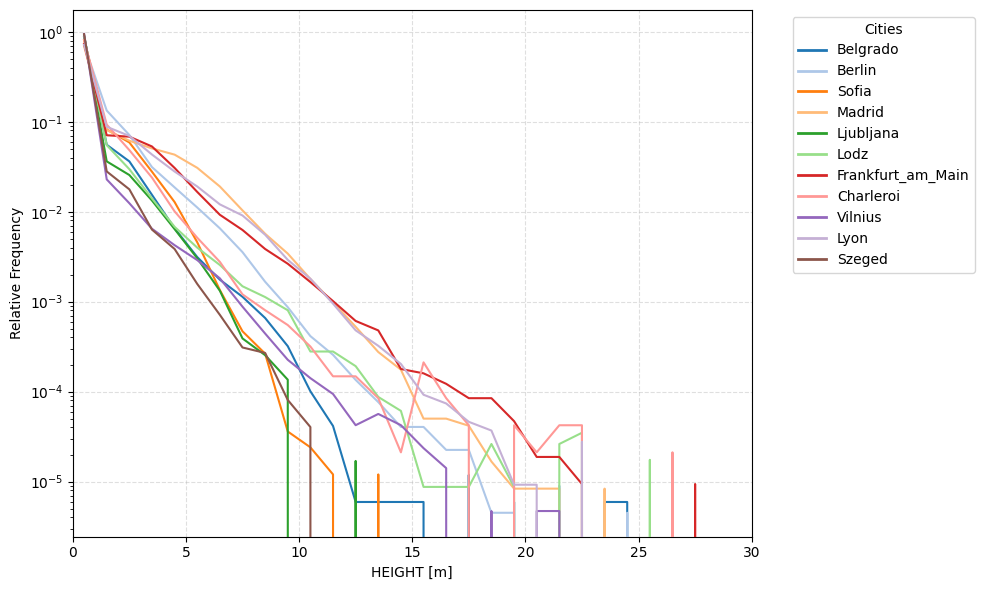

In [56]:

# === CONFIGURATION ===
cluster = 'CL1'
feature = 'HEIGHT'
bin_width = 1
x_min, x_max = 0, 30
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [m]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



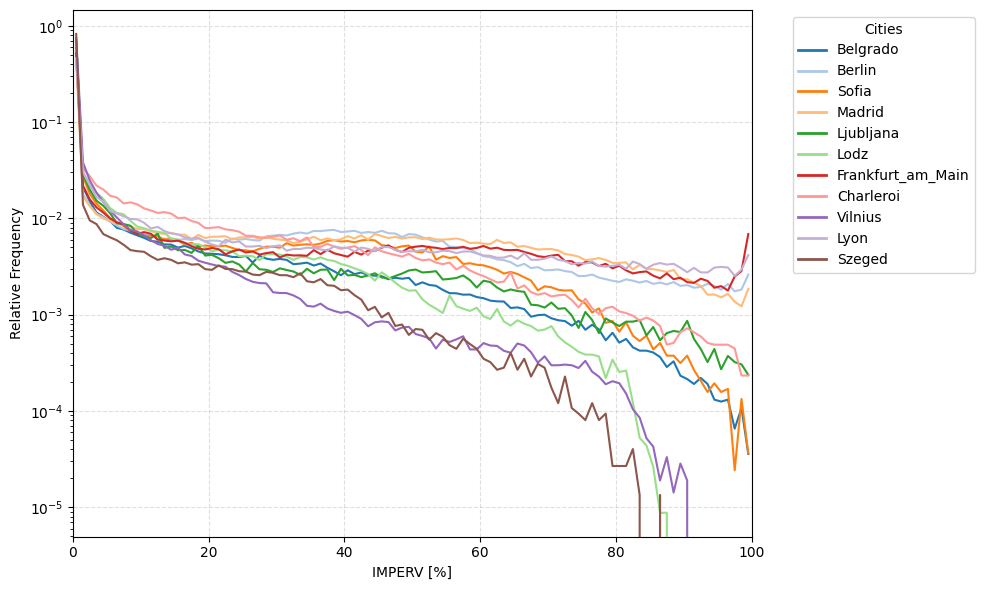

In [44]:

# === CONFIGURATION ===
cluster = 'CL1'
feature = 'IMPERV'
bin_width = 1
x_min, x_max = 0, 100
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [%]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



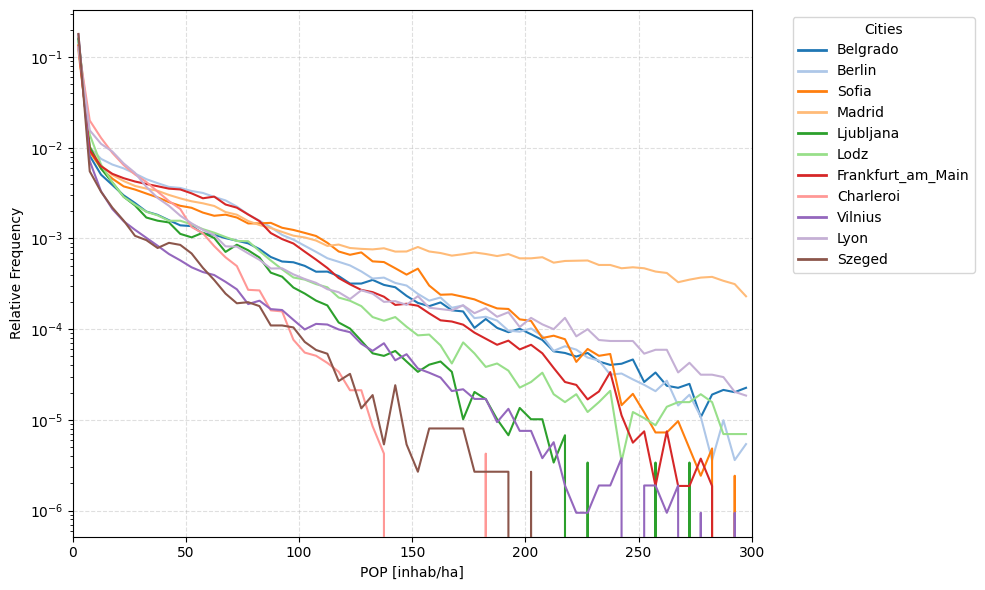

In [45]:

# === CONFIGURATION ===
cluster = 'CL1'
feature = 'POP'
bin_width = 5
x_min, x_max = 0, 300
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [inhab/ha]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



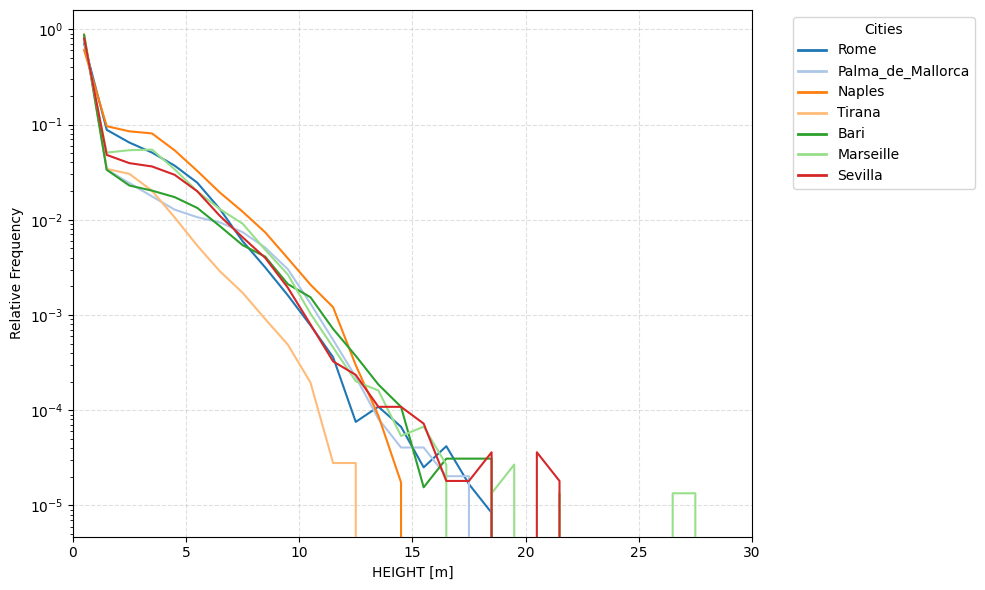

In [47]:

# === CONFIGURATION ===
cluster = 'CL2'
feature = 'HEIGHT'
bin_width = 1
x_min, x_max = 0, 30
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [m]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



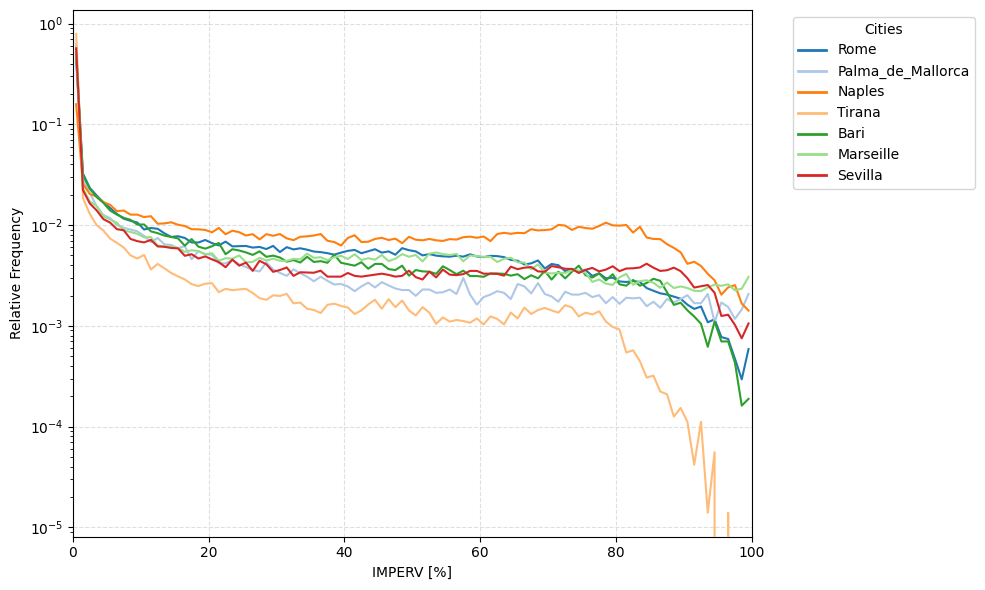

In [46]:

# === CONFIGURATION ===
cluster = 'CL2'
feature = 'IMPERV'
bin_width = 1
x_min, x_max = 0, 100
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [%]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



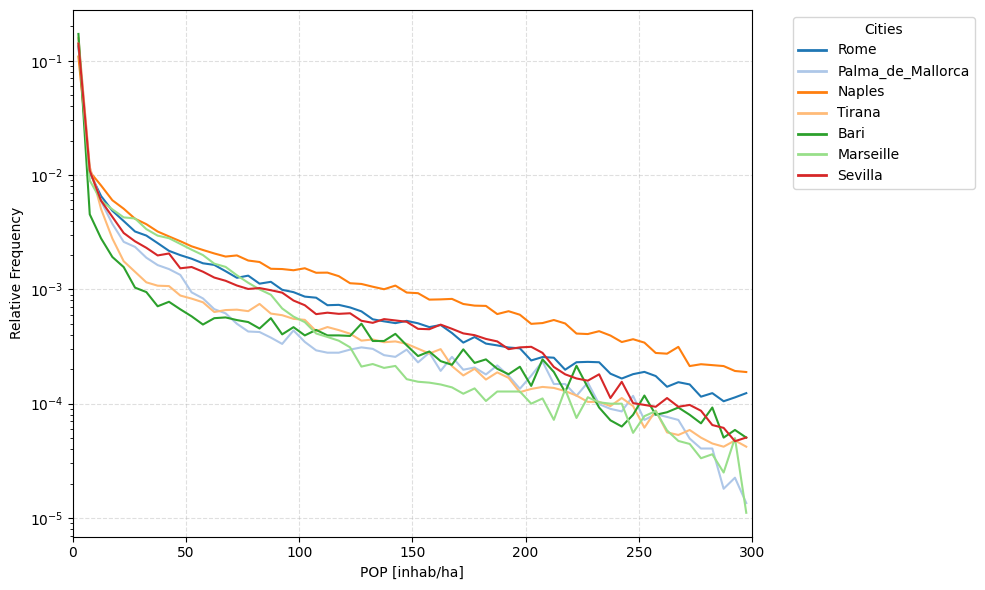

In [49]:

# === CONFIGURATION ===
cluster = 'CL2'
feature = 'POP'
bin_width = 5
x_min, x_max = 0, 300
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [inhab/ha]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



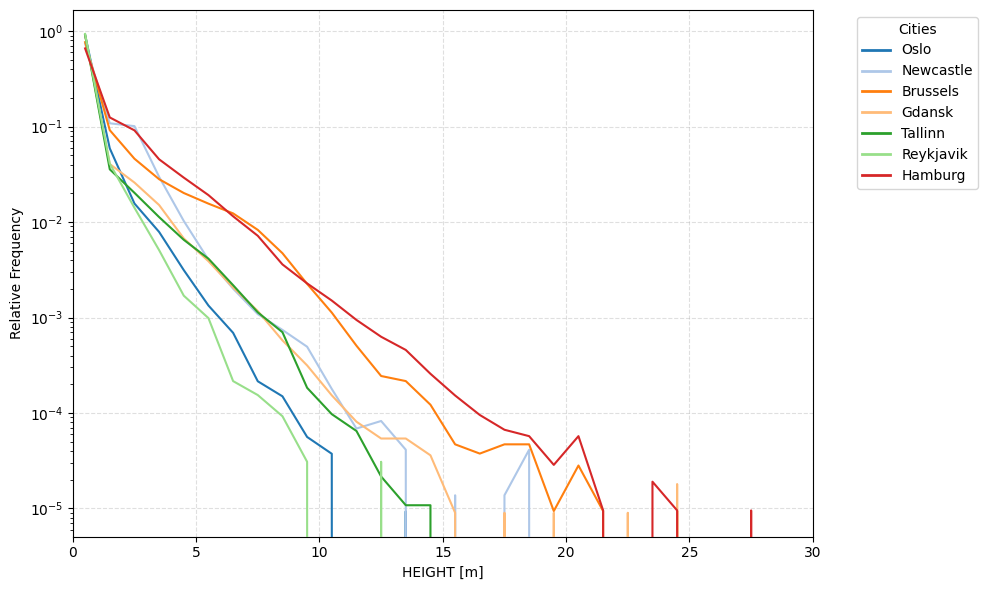

In [50]:

# === CONFIGURATION ===
cluster = 'CL3'
feature = 'HEIGHT'
bin_width = 1
x_min, x_max = 0, 30
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [m]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



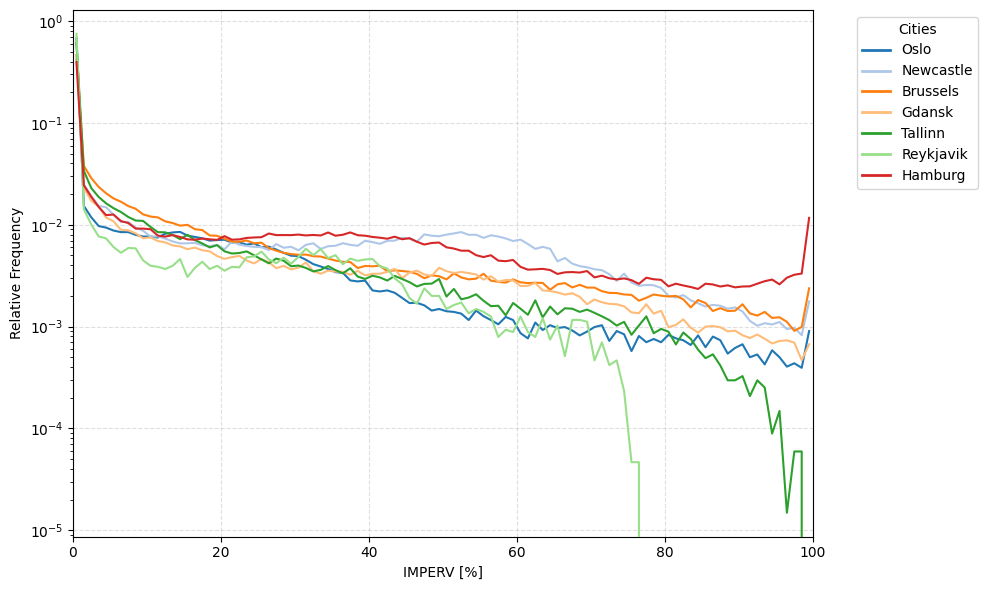

In [51]:

# === CONFIGURATION ===
cluster = 'CL3'
feature = 'IMPERV'
bin_width = 1
x_min, x_max = 0, 100
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [%]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



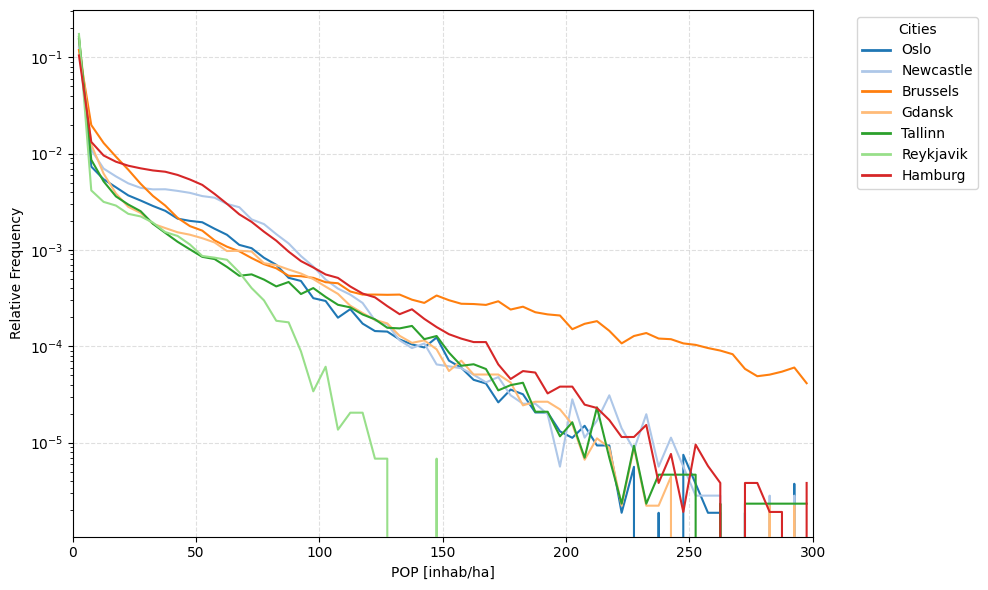

In [52]:

# === CONFIGURATION ===
cluster = 'CL3'
feature = 'POP'
bin_width = 5
x_min, x_max = 0, 300
valid_lc_corine_values = np.arange(1,16)
data_dir = "data/raster_total"
columns_to_check = ['LC_CORINE', feature]  # To ensure required columns exist

# === BINS DEFINITION ===
bins = np.arange(x_min, x_max + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === COLORS FOR CITIES ===
import itertools
color_cycle = itertools.cycle(plt.cm.tab20.colors)

# === COLLECT HISTOGRAMS ===
histograms = {}
city_colors = {}

for city in city_clusters[cluster]:
    file_path = os.path.join(data_dir, f"total_{city}.csv")
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in columns_to_check):
        print(f"Missing required columns in {city}")
        continue

    # Filter by LC_CORINE
    filtered = df[df['LC_CORINE'].isin(valid_lc_corine_values)][feature].dropna()

    # Normalize histogram
    counts, _ = np.histogram(filtered, bins=bins, density=True)
    histograms[city] = counts
    city_colors[city] = next(color_cycle)

# === DETERMINE PLOTTING ORDER BASED ON MAX HEIGHT PER BIN ===
# For each bin, sort cities by their value so smaller values get drawn last (on top)
bin_city_layers = []
for i in range(len(bins) - 1):
    bin_heights = {city: histograms[city][i] for city in histograms}
    sorted_cities = sorted(bin_heights.items(), key=lambda x: -x[1])  # descending
    bin_city_layers.append([city for city, _ in sorted_cities])

# === PLOT OVERLAPPING LINE PLOTS ===
plt.figure(figsize=(10, 6))

# For each city, plot the histogram as a line
for city in histograms:
    plt.plot(bin_centers, histograms[city], color=city_colors[city], alpha=1, 
             label=city, zorder=10)

# === PLOT SETTINGS ===
plt.xlim(x_min, x_max)
plt.xlabel(f'{feature} [inhab/ha]')
plt.ylabel("Relative Frequency")
#plt.title(f"Overlapping Normalized Line Plots of {feature} in Cluster {cluster}")
plt.grid(True, linestyle='--', alpha=0.4)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Unique legend
handles = [plt.Line2D([0], [0], color=color, label=city, linewidth=2)
           for city, color in city_colors.items()]
plt.legend(handles=handles, title="Cities", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.show()



In [ ]:

# Load min/max info
min_max_file = "data/total_min_max.csv"
min_max_df = pd.read_csv(min_max_file, sep=';')
input_ranges = min_max_df['Max'] - min_max_df['min']
input_ranges.index = min_max_df['Unnamed: 0']

t_target_min = min_max_df.loc[16, 'min']
t_target_max = min_max_df.loc[16, 'Max']
delta = 0.1 * input_ranges

allowed_sensitivity_columns = ['HEIGHT', 'POP', 'IMPERV']
allowed_indices = [columns_order.index(col) for col in allowed_sensitivity_columns]
midpoints = {
    row['Unnamed: 0']: (row['min'] + row['Max']) / 2
    for _, row in min_max_df.iterrows()
    if row['Unnamed: 0'] in allowed_sensitivity_columns
}

warnings.filterwarnings("ignore")

for cluster, cities in city_clusters.items():
    model = models[cluster]
    for city in cities:
        print(f"Processing {city} in cluster {cluster}...")
        file_path = f"data/raster_total/total_{city}.csv"
        data = pd.read_csv(file_path).dropna()

        # Manual feature overrides
        data['SP'] = 105000
        data['RH'] = 0
        data['PRECIP'] = 0
        data['WS'] = 0
        data['T_2M_COR'] = 305
        data['TCC'] = 0
        data['BLH'] = 15
        data['SSR'] = 0
        data['SOLAR_ELEV'] = -76
        data['DECL'] = 23
        data['CAPE'] = 4000
        data['T_2M_COR'] = data['T_2M_COR'] - 273.15
        data2 = data[columns_order]

        n_allowed = len(allowed_indices)
        sample_plus = np.repeat(data2, n_allowed, axis=0)
        sample_minus = np.repeat(data2, n_allowed, axis=0)

        for idx_in_allowed, feature_idx in enumerate(allowed_indices):
            sample_minus[idx_in_allowed::n_allowed, feature_idx] -= 0.5 * sample_minus[idx_in_allowed::n_allowed, feature_idx]

        if np.any(np.isnan(sample_plus)) or np.any(np.isnan(sample_minus)):
            print("NaNs in perturbed samples — replacing with midpoints.")
            for idx_in_allowed, feature_idx in enumerate(allowed_indices):
                feature_name = allowed_sensitivity_columns[idx_in_allowed]
                midpoint = midpoints[feature_name]
                sample_plus[np.isnan(sample_plus[:, feature_idx]), feature_idx] = midpoint
                sample_minus[np.isnan(sample_minus[:, feature_idx]), feature_idx] = midpoint

        sample_plus = np.clip(sample_plus, -1e10, 1e10)
        sample_minus = np.clip(sample_minus, -1e10, 1e10)
        perturbations = np.vstack((sample_plus, sample_minus))

        try:
            outputs = model.predict(perturbations)
        except ValueError as e:
            print(f"Prediction error for {city}: {e}")
            continue

        output_plus = outputs[:len(data) * n_allowed].reshape(len(data), n_allowed)
        output_minus = outputs[len(data) * n_allowed:].reshape(len(data), n_allowed)
        sensitivities_batch = (output_minus - output_plus)

        # Assign sensitivity results to DataFrame
        data = data.reset_index(drop=True)
        for i, feature in enumerate(allowed_sensitivity_columns):
            data[f"SI_{feature}"] = sensitivities_batch[:, i]

        # Pivot the data to 2D grid based on x and y
        x_unique = np.sort(data['x'].unique())
        y_unique = np.sort(data['y'].unique())[::-1]  # reverse y for top-down

        x_dim, y_dim = len(x_unique), len(y_unique)
        x_coords = x_unique
        y_coords = y_unique

        ds = xr.Dataset()

        for col in data.columns:
            if col in ['x', 'y']:
                continue
            z = np.full((y_dim, x_dim), np.nan)
            for _, row in data.iterrows():
                try:
                    xi = np.where(x_coords == row['x'])[0][0]
                    yi = np.where(y_coords == row['y'])[0][0]
                    z[yi, xi] = row[col]
                except IndexError:
                    continue
            ds[col] = (['y', 'x'], z)

        ds = ds.assign_coords({'x': x_coords, 'y': y_coords})

        #  Define geotransform
        pixel_width = np.diff(x_coords).mean()
        pixel_height = np.diff(y_coords).mean()
        transform = from_origin(x_coords[0], y_coords[0], pixel_width, -pixel_height)

        #  Assign CRS and transform
        ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
        ds.rio.write_crs("EPSG:4326", inplace=True)
        ds.rio.write_transform(transform, inplace=True)

        # Save to NetCDF
        save_dir = os.path.join("Figures", cluster, "case_studies_files")
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{city}.nc")
        ds.to_netcdf(save_path)
        print(f"Saved: {save_path}")


Processing Sofia in cluster CL1...
Saved: Figures\CL1\case_studies_files\Sofia.nc
Processing Charleroi in cluster CL1...
Saved: Figures\CL1\case_studies_files\Charleroi.nc
Processing Berlin in cluster CL1...
Saved: Figures\CL1\case_studies_files\Berlin.nc
Processing Ljubljana in cluster CL1...
Saved: Figures\CL1\case_studies_files\Ljubljana.nc
Processing Madrid in cluster CL1...
Saved: Figures\CL1\case_studies_files\Madrid.nc
Processing Belgrado in cluster CL1...
Saved: Figures\CL1\case_studies_files\Belgrado.nc
Processing Frankfurt_am_Main in cluster CL1...
Saved: Figures\CL1\case_studies_files\Frankfurt_am_Main.nc
Processing Lyon in cluster CL1...
Saved: Figures\CL1\case_studies_files\Lyon.nc
Processing Lodz in cluster CL1...
Saved: Figures\CL1\case_studies_files\Lodz.nc
Processing Vilnius in cluster CL1...
Saved: Figures\CL1\case_studies_files\Vilnius.nc
Processing Szeged in cluster CL1...
Saved: Figures\CL1\case_studies_files\Szeged.nc
Processing Rome in cluster CL2...
Saved: Figur

In [26]:
data

x          y       COAST       ELEV    HEIGHT  IMPERV  POP  \
0       13.035897  52.704938  134.077737  59.833946  0.000000     0.0  0.0   
1       13.037032  52.704938  134.059195  57.669740  0.000000     0.0  0.0   
2       13.038167  52.704938  134.040653  55.048767  0.000000     0.0  0.0   
3       13.039302  52.704938  134.022112  55.608010  0.000000     0.0  0.0   
4       13.040437  52.704938  134.003570  57.002220  0.000031     0.0  0.0   
...           ...        ...         ...        ...       ...     ...  ...   
219767  13.788368  52.332675  148.579553  47.242310  0.000000     0.0  0.0   
219768  13.789503  52.332675  148.554650  46.721066  0.000000     0.0  0.0   
219769  13.790638  52.332675  148.529747  45.974280  0.000000     0.0  0.0   
219770  13.791773  52.332675  148.504844  43.931680  0.000000     0.0  0.0   
219771  13.792908  52.332675  148.479941  42.051712  0.000000     0.0  0.0   

        LC_CORINE      SP  RH  ...  T_2M_COR  TCC  BLH  SSR  SOLAR_ELEV  DECL  \
0              12  105000   0  ...     31.85    0   15    0         -76    23   
1              12  105000   0  ...     31.85    0   15    0         -76    23   
2              12  105000   0  ...     31.85    0   15    0         -76    23   
3              12  105000   0  ...     31.85    0   15    0         -76    23   
4              12  105000   0  ...     31.85    0   15    0         -76    23   
...           ...     ...  ..  ...       ...  ...  ...  ...         ...   ...   
219767         12  105000   0  ...     31.85    0   15    0         -76    23   
219768         12  105000   0  ...     31.85    0   15    0         -76    23   
219769         12  105000   0  ...     31.85    0   15    0         -76    23   
219770         12  105000   0  ...     31.85    0   15    0         -76    23   
219771         12  105000   0  ...     31.85    0   15    0         -76    23   

        CAPE  SI_HEIGHT  SI_POP  SI_IMPERV  
0       4000        0.0     0.0        0.0  
1       4000        0.0     0.0        0.0  
2       4000        0.0     0.0        0.0  
3       4000        0.0     0.0        0.0  
4       4000        0.0     0.0        0.0  
...      ...        ...     ...        ...  
219767  4000        0.0     0.0        0.0  
219768  4000        0.0     0.0        0.0  
219769  4000        0.0     0.0        0.0  
219770  4000        0.0     0.0        0.0  
219771  4000        0.0     0.0        0.0  

[219772 rows x 22 columns]

In [3]:

# Choose city
city = 'Brussels'

# Select correct model
if city in CL1_cities:
    model = model_CL1
elif city in CL2_cities:
    model = model_CL2
elif city in CL3_cities:
    model = model_CL3
else:
    raise ValueError(f"City '{city}' not recognized in any model group.")

# Read data
file_path = f"data/raster_total/total_{city}.csv"
data = pd.read_csv(file_path)
min_max_file = r"data/total_min_max.csv"

warnings.filterwarnings("ignore")

# Preprocessing
data = data.dropna()
data['SP'] = 102000
data['RH'] = 30
data['PRECIP'] = 0
data['WS'] = 1
data['T_2M_COR'] = 298
data['TCC'] = 0
data['BLH'] = 150
data['SSR'] = 0
data['SOLAR_ELEV'] = -50
data['DECL'] = 20
data['CAPE'] = 500
data['T_2M_COR'] = data['T_2M_COR'] - 273.15
data2 = data[columns_order]

# Load min-max info
min_max_df = pd.read_csv(min_max_file, sep=';')
input_ranges = min_max_df['Max'] - min_max_df['min']
input_ranges.index = min_max_df['Unnamed: 0']

t_target_min = min_max_df.loc[16, 'min']
t_target_max = min_max_df.loc[16, 'Max']
delta = 0.1 * input_ranges

allowed_sensitivity_columns = ['HEIGHT', 'POP', 'IMPERV']
allowed_indices = [columns_order.index(col) for col in allowed_sensitivity_columns]
midpoints = {
    row['Unnamed: 0']: (row['min'] + row['Max']) / 2
    for _, row in min_max_df.iterrows()
    if row['Unnamed: 0'] in allowed_sensitivity_columns
}

n_allowed = len(allowed_indices)

# Perturbations
sample_plus = np.repeat(data2, n_allowed, axis=0)
sample_minus = np.repeat(data2, n_allowed, axis=0)

for idx_in_allowed, feature_idx in enumerate(allowed_indices):
    sample_plus[idx_in_allowed::n_allowed, feature_idx]  # Could modify with delta
    sample_minus[idx_in_allowed::n_allowed, feature_idx] -= 0.5 * sample_minus[idx_in_allowed::n_allowed, feature_idx]

if np.any(np.isnan(sample_plus)) or np.any(np.isnan(sample_minus)):
    print("NaNs in perturbed samples — replacing with midpoints.")
    for idx_in_allowed, feature_idx in enumerate(allowed_indices):
        feature_name = allowed_sensitivity_columns[idx_in_allowed]
        midpoint = midpoints[feature_name]
        sample_plus[np.isnan(sample_plus[:, feature_idx]), feature_idx] = midpoint
        sample_minus[np.isnan(sample_minus[:, feature_idx]), feature_idx] = midpoint

sample_plus = np.clip(sample_plus, -1e10, 1e10)
sample_minus = np.clip(sample_minus, -1e10, 1e10)
perturbations = np.vstack((sample_plus, sample_minus))

try:
    outputs = model.predict(perturbations)
except ValueError as e:
    print(f"Prediction error: {e}")

output_plus = outputs[:len(data) * n_allowed].reshape(len(data), n_allowed)
output_minus = outputs[len(data) * n_allowed:].reshape(len(data), n_allowed)

sensitivities_batch = (output_minus - output_plus)

print("Processing complete.")

data = data.reset_index()
data['SI_HEIGHT'] = 0
data['SI_POP'] = 0
data['SI_IMPERV'] = 0
for i in np.arange(0, len(sensitivities_batch)):
    data['SI_HEIGHT'][i] = sensitivities_batch[i][0]
    data['SI_POP'][i] = sensitivities_batch[i][1]
    data['SI_IMPERV'][i] = sensitivities_batch[i][2]

Processing complete.


Brussels:

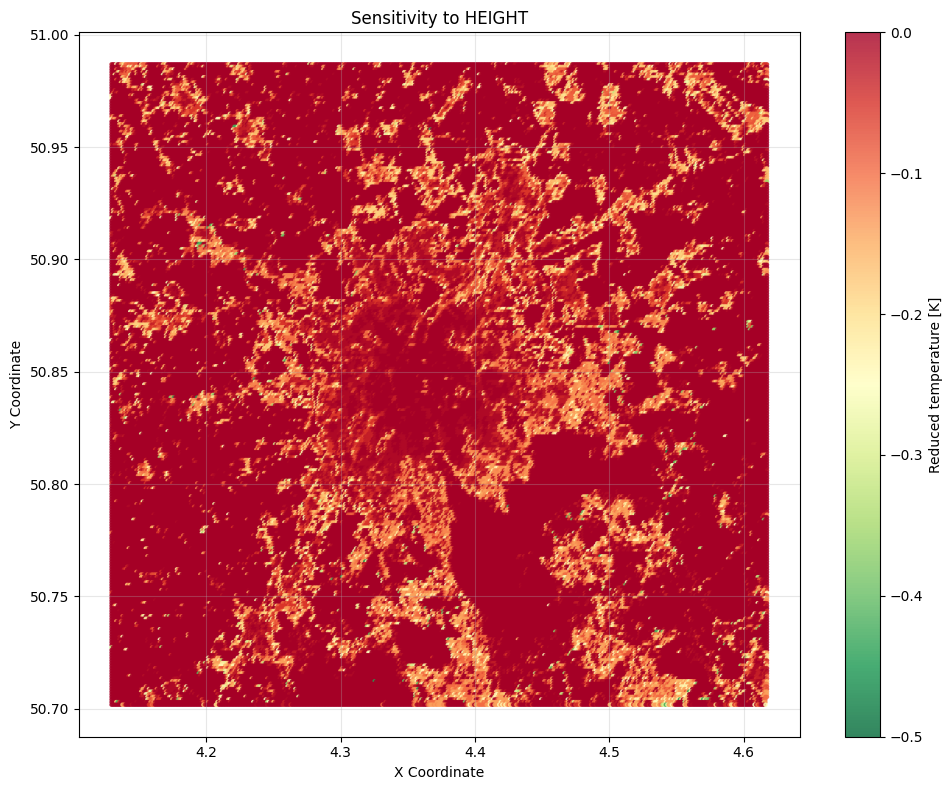

In [4]:

plt.figure(figsize=(10, 8))
sc = plt.scatter(data['x'], data['y'], c=data['SI_HEIGHT'], cmap='RdYlGn_r', s=5, alpha=0.8, vmax = 0, vmin = -0.5)
plt.colorbar(sc, label='Reduced temperature [K]')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sensitivity to HEIGHT')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

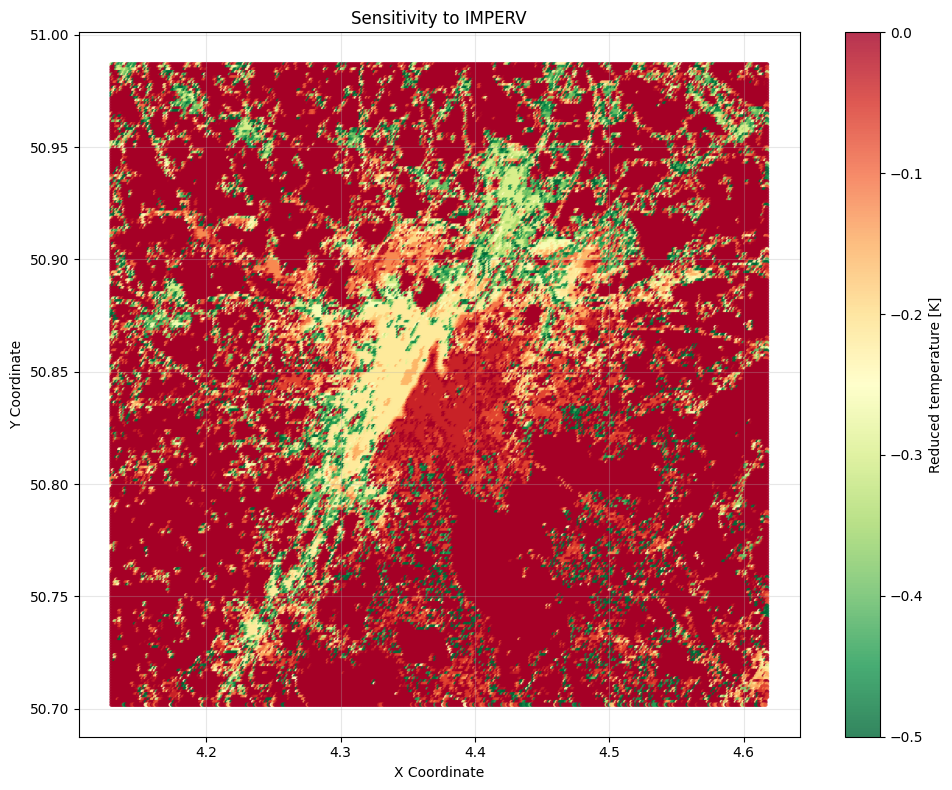

In [9]:

plt.figure(figsize=(10, 8))
sc = plt.scatter(data['x'], data['y'], c=data['SI_IMPERV'], cmap='RdYlGn_r', s=5, alpha=0.8, vmax = 0, vmin = -0.5)
plt.colorbar(sc, label='Reduced temperature [K]')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sensitivity to IMPERV')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

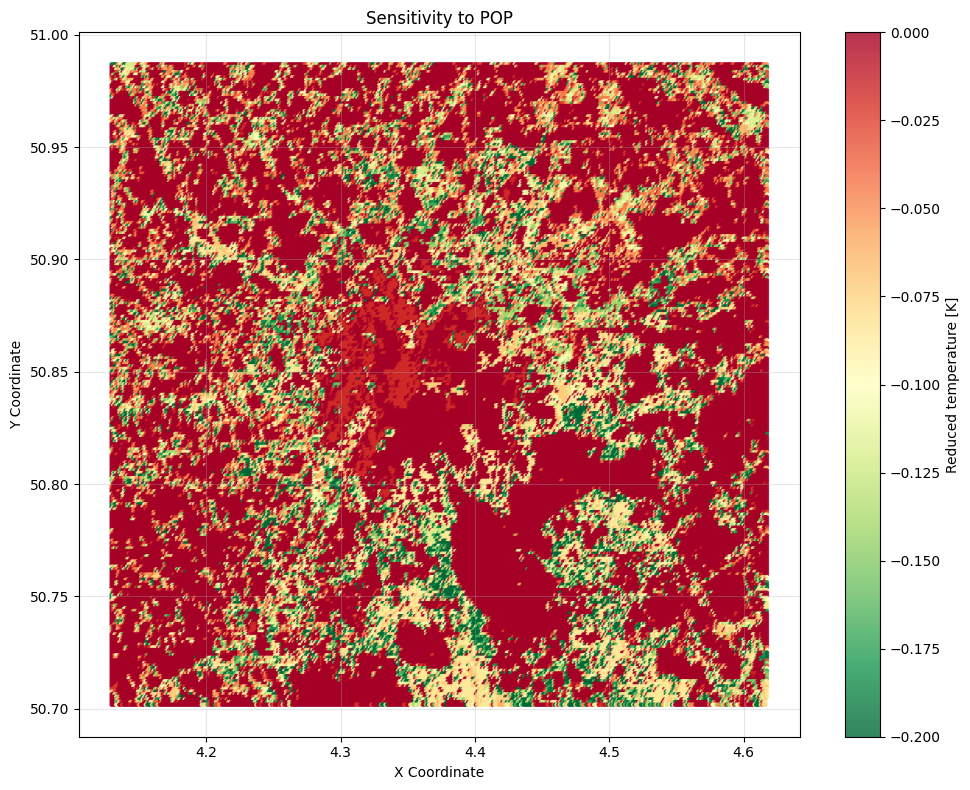

In [11]:

plt.figure(figsize=(10, 8))
sc = plt.scatter(data['x'], data['y'], c=data['SI_POP'], cmap='RdYlGn_r', s=5, alpha=0.8, vmax = 0, vmin = -0.2)
plt.colorbar(sc, label='Reduced temperature [K]')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sensitivity to POP')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Choose city
city = 'Naples'

# Select correct model
if city in CL1_cities:
    model = model_CL1
elif city in CL2_cities:
    model = model_CL2
elif city in CL3_cities:
    model = model_CL3
else:
    raise ValueError(f"City '{city}' not recognized in any model group.")

# Read data
file_path = f"data/raster_total/total_{city}.csv"
data = pd.read_csv(file_path)
min_max_file = r"data/total_min_max.csv"

warnings.filterwarnings("ignore")

# Preprocessing
data = data.dropna()
data['SP'] = 102000
data['RH'] = 30
data['PRECIP'] = 0
data['WS'] = 1
data['T_2M_COR'] = 298
data['TCC'] = 0
data['BLH'] = 150
data['SSR'] = 0
data['SOLAR_ELEV'] = -50
data['DECL'] = 20
data['CAPE'] = 500
data['T_2M_COR'] = data['T_2M_COR'] - 273.15
data_original = data[columns_order]

# Create modified version with LC_CORINE = 4
data_modified = data.copy()
data_modified['LC_CORINE'] = 7
data_modified = data_modified[columns_order]

# Run model predictions
try:
    output_original = model.predict(data_original)
    output_modified = model.predict(data_modified)
except ValueError as e:
    print(f"Prediction error: {e}")

# Calculate difference in outputs due to LC_CORINE change
lc_corine_effect = output_modified - output_original

# Add to original DataFrame for inspection
data = data.reset_index()
data['LC_CORINE_EFFECT'] = lc_corine_effect

print("LC_CORINE effect analysis complete.")


LC_CORINE effect analysis complete.


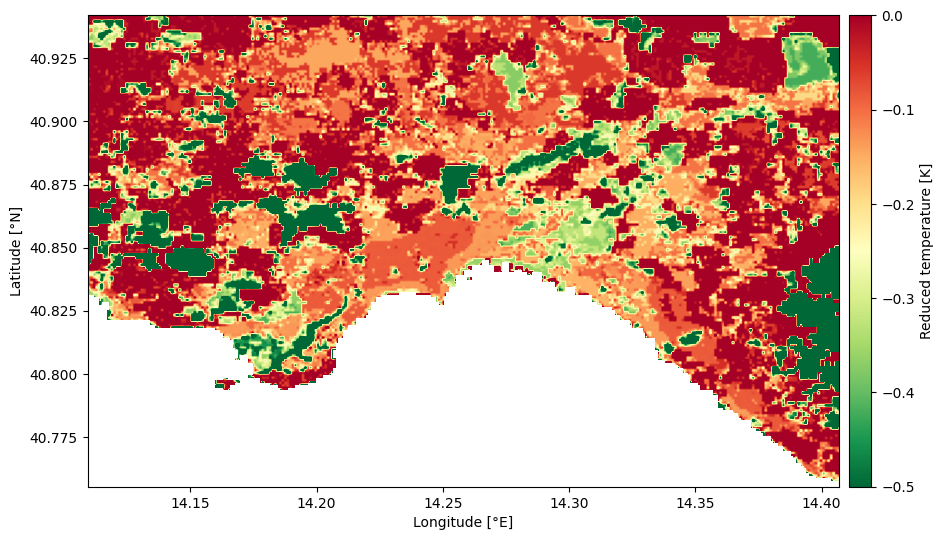

In [34]:
# Ensure y-axis is sorted top-down
x_unique = np.sort(data['x'].unique())
y_unique = np.sort(data['y'].unique())[::-1]  # Reverse y for image-style plotting

x_dim, y_dim = len(x_unique), len(y_unique)

# Plot and save each sensitivity map
for feature, vmin in zip(['LC_CORINE_EFFECT'], [-0.5, -0.5, -0.5]):
    # Build 2D grid
    z = np.full((y_dim, x_dim), np.nan)
    for _, row in data.iterrows():
        xi = np.where(x_unique == row['x'])[0][0]
        yi = np.where(y_unique == row['y'])[0][0]
        z[yi, xi] = row[f'{feature}']

    aspect_ratio = x_dim / y_dim
    base_height = 6  # You can adjust this
    fig, ax = plt.subplots(figsize=(base_height * aspect_ratio, base_height))
    im = ax.imshow(z, cmap='RdYlGn_r', vmax=0, vmin=vmin,
                extent=(x_unique[0], x_unique[-1], y_unique[-1], y_unique[0]))

    # Create a divider for the axes and add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Reduced temperature [K]')

    # Adjust colorbar height (e.g., 60% of plot height)
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    #ax.set_title(f'Sensitivity to {feature}')
    ax.grid(False)
    plt.tight_layout()
    plt.show()

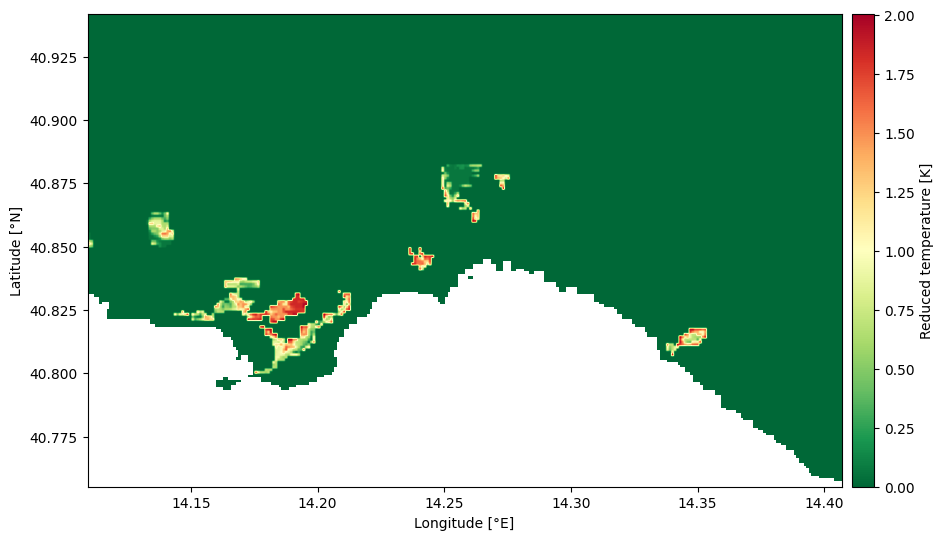

In [15]:
# Ensure y-axis is sorted top-down
x_unique = np.sort(data['x'].unique())
y_unique = np.sort(data['y'].unique())[::-1]  # Reverse y for image-style plotting

x_dim, y_dim = len(x_unique), len(y_unique)

# Plot and save each sensitivity map
for feature, vmin in zip(['LC_CORINE_EFFECT'], [-0.5, -0.5, -0.5]):
    # Build 2D grid
    z = np.full((y_dim, x_dim), np.nan)
    counter = 0
    for _, row in data.iterrows():
        xi = np.where(x_unique == row['x'])[0][0]
        yi = np.where(y_unique == row['y'])[0][0]
        z[yi, xi] = output_original[counter] * (row['LC_CORINE']==4)
        counter += 1 

    aspect_ratio = x_dim / y_dim
    base_height = 6  # You can adjust this
    fig, ax = plt.subplots(figsize=(base_height * aspect_ratio, base_height))
    im = ax.imshow(z, cmap='RdYlGn_r',#, vmax=0, vmin=vmin,
                extent=(x_unique[0], x_unique[-1], y_unique[-1], y_unique[0]))

    # Create a divider for the axes and add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Reduced temperature [K]')

    # Adjust colorbar height (e.g., 60% of plot height)
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    #ax.set_title(f'Sensitivity to {feature}')
    ax.grid(False)
    plt.tight_layout()
    plt.show()

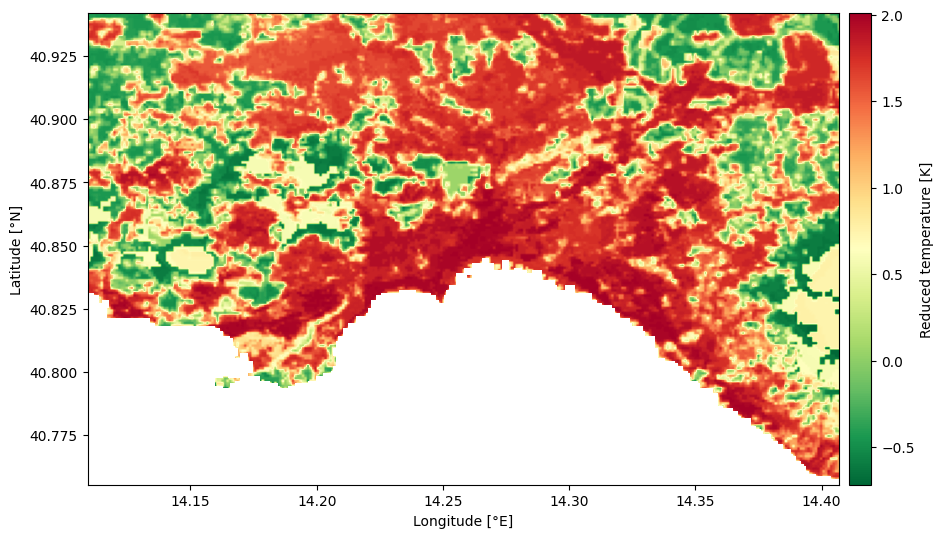

In [32]:
# Ensure y-axis is sorted top-down
x_unique = np.sort(data['x'].unique())
y_unique = np.sort(data['y'].unique())[::-1]  # Reverse y for image-style plotting

x_dim, y_dim = len(x_unique), len(y_unique)

# Plot and save each sensitivity map
for feature, vmin in zip(['LC_CORINE_EFFECT'], [-0.5, -0.5, -0.5]):
    # Build 2D grid
    z = np.full((y_dim, x_dim), np.nan)
    counter = 0
    for _, row in data.iterrows():
        xi = np.where(x_unique == row['x'])[0][0]
        yi = np.where(y_unique == row['y'])[0][0]
        z[yi, xi] = output_original[counter]
        counter += 1 

    aspect_ratio = x_dim / y_dim
    base_height = 6  # You can adjust this
    fig, ax = plt.subplots(figsize=(base_height * aspect_ratio, base_height))
    im = ax.imshow(z, cmap='RdYlGn_r',#, vmax=0, vmin=vmin,
                extent=(x_unique[0], x_unique[-1], y_unique[-1], y_unique[0]))

    # Create a divider for the axes and add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Reduced temperature [K]')

    # Adjust colorbar height (e.g., 60% of plot height)
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    #ax.set_title(f'Sensitivity to {feature}')
    ax.grid(False)
    plt.tight_layout()
    plt.show()

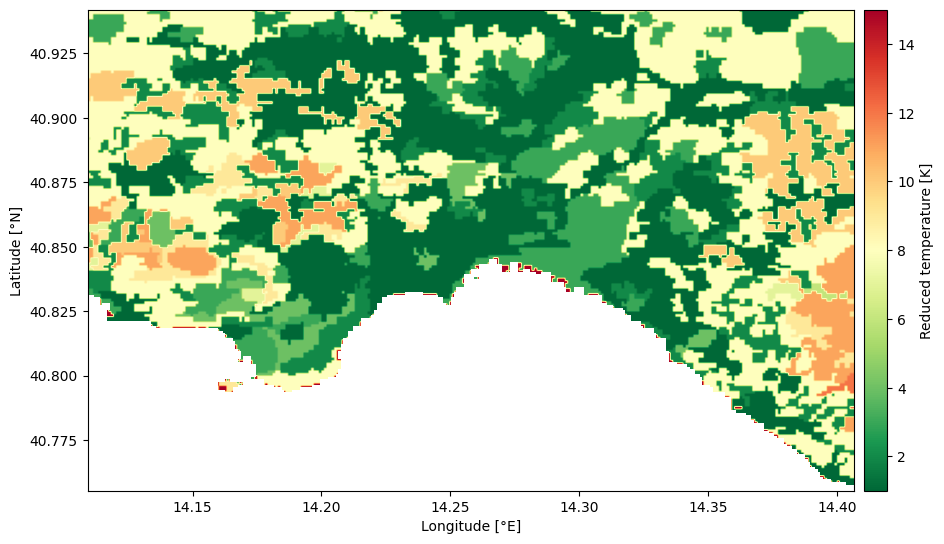

In [14]:
# Ensure y-axis is sorted top-down
x_unique = np.sort(data['x'].unique())
y_unique = np.sort(data['y'].unique())[::-1]  # Reverse y for image-style plotting

x_dim, y_dim = len(x_unique), len(y_unique)

# Plot and save each sensitivity map
for feature, vmin in zip(['LC_CORINE'], [-0.5, -0.5, -0.5]):
    # Build 2D grid
    z = np.full((y_dim, x_dim), np.nan)
    for _, row in data.iterrows():
        xi = np.where(x_unique == row['x'])[0][0]
        yi = np.where(y_unique == row['y'])[0][0]
        z[yi, xi] = row[f'{feature}']

    aspect_ratio = x_dim / y_dim
    base_height = 6  # You can adjust this
    fig, ax = plt.subplots(figsize=(base_height * aspect_ratio, base_height))
    im = ax.imshow(z, cmap='RdYlGn_r',# vmax=0, vmin=vmin,
                extent=(x_unique[0], x_unique[-1], y_unique[-1], y_unique[0]))

    # Create a divider for the axes and add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Reduced temperature [K]')

    # Adjust colorbar height (e.g., 60% of plot height)
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + pos.height * 0.2, pos.width, pos.height * 0.6])

    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    #ax.set_title(f'Sensitivity to {feature}')
    ax.grid(False)
    plt.tight_layout()
    plt.show()